## Introduction

In this notebook, we will demonstrate how to use the [`censusdis`](https://github.com/vengroff/censusdis) package 
to download some US Census data and then how to use the [`divintseg`](https://github.com/vengroff/divintseg) package 
to compute some diversity and integration metrics.

In this example, we will look at US Census redistricting data from the towns of South Orange
and Maplewood (collectively known as SoMa) in Essex County,
NJ. We chose redistricting data because it has the demographic data we are interested in
studying, including race and ethnicity.

Once you are familiar with the API and how to use it, you can easily experiment with
similar analysis of the area where you live.

## Environment Setup

We assume you are running this notebook in an environment where the necessary 
packages have been `pip` installed. You should be able to get everything you
need with just 

```
pip install censusdis
```

which will also install `divintseg` and various other dependencies.

## Imports

We need to import out resistricting data API, some utilities for getting map data, and the 
[`divintseg`](https://github.com/vengroff/divintseg) 
package that computes diversity and integration metrics, along with `pandas` for some basic data
manipulation.

In [1]:
import censusdis.redistricting as crd

from censusdis.states import STATE_NJ
from censusdis.maps import ShapeReader

import divintseg as dis

import pandas as pd

## US Census API Key

The US Census API uses a key to identify callers. If you don't already have a key, you can request
one [here](https://api.census.gov/data/key_signup.html). Please put your key into this cell before 
running the notebook.

For small queries like in this demo notebook, the API seems to work without a key, so you can leave
it set to `None`, but for more serious work you will want to obtain a key.

In [2]:
CENSUS_API_KEY = None

## Basic Configuration

### Year

We can choose which census year we want to look at, 2000, 2010, or 2020.

In [3]:
YEAR = 2020

### Field Group

A field group is a set of fields that the US Census uses to provide data
in the various data sets it publishes. These groups cover all kinds of
topics. We are interested in demographics and we are going to be using
redistricting data, so the field groups available are those summarized 
[here](https://api.census.gov/data/2020/dec/pl/groups.html). Don't worry
if nothing on that page means anything to you right now. We'll explain it
here.

If we choose P1, then the data is grouped purely based on race, 
not taking ethnicity into account at all. If we choose P2, then the data is
first grouped by ethnicity, with people reporting Hispanic or Latino ethinicity
put into one group regardless of their race. Everyone else is then divided into
groups based on their race.

Thus, P2 has one group that P1 does not have, which is Hispanic or Latino of 
any race. In the P1 data set, people who are in the Hispanic or Latino group 
in P2 are instead classified into one of the race-based groups. 

For more information, including additional options P3 and P4, see this
additional 
[documentation](https://www.census.gov/programs-surveys/decennial-census/about/rdo/summary-files.html).

In [4]:
FIELD_GROUP = "P2"

### Fields

Since the specific fields that exist within a field group vary by year,
we have to make a metadata query to find out what they are. This is a
simple one-liner.

In [5]:
field_names, total_field, fields_by_race = crd.metadata(YEAR, FIELD_GROUP)

Each of the fields has a name (in `field_names`), and the API also groups them into 
racial groups (in `fields by race`) in case we want to use that for additional 
analysis. 

For the work we are doing here, we are just going to pass some of this metadata
on to our data query. But we will take a quick look just to see the richness of the
data provided by the census for people who are multiracial.

In [6]:
field_names

{'P2_070N': 'White; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race',
 'P2_071N': 'Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race',
 'P2_073N': 'White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race',
 'P2_060N': 'Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander',
 'P2_030N': 'White; Black or African American; Asian',
 'P2_054N': 'White; Black or African American; Asian; Some Other Race',
 'P2_042N': 'Black or African American; Asian; Native Hawaiian and Other Pacific Islander',
 'P2_066N': 'White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander',
 'P2_043N': 'Black or African American; Asian; Some Other Race',
 'P2_031N': 'White; Black or African

## South Orange and Maplewood Tracts in Essex County, NJ

We want to take a look at data from the towns of South Orange
and Maplewood (collectively known as SoMa) in Essex County,
NJ. 

### Essex County

For Essex County, we found the code `'013`' on this 
[wikipedia page](https://en.wikipedia.org/wiki/List_of_counties_in_New_Jersey).

In [7]:
COUNTY_ESSEX_NJ = "013"

### SoMa Tracts

We found the tracts that make up the two towns by looking
at 
[this map](https://www2.census.gov/geo/maps/dc10map/tract/st34_nj/c34013_essex/DC10CT_C34013_002.pdf).
We format them as strings using the convention of
Census API, which is a six-digit string.

In [8]:
tracts_soma = [f"{t:06}" for t in range(19000, 20000, 100)]
tracts_soma

['019000',
 '019100',
 '019200',
 '019300',
 '019400',
 '019500',
 '019600',
 '019700',
 '019800',
 '019900']

### SoMa Data Query

Now we can query the data. Lets look at the arguments to our call one by one:

- `STATE_NJ` - this is the state we are interested in.
- `YEAR`- the year we want data for. For the redistricting API, 2000, 2010, and 2020 are the three valid option.
- `block` - the resolution of data we want. We want a row for each block in SoMa. 
- `field_names.keys()` - these are all the fields we want data for. The available fields vary by year and group, which
   is why we made the `crd.metadata` call above to get them.
- `county=COUNTY_ESSEX_NJ` - this is a filter. We only want data for Essex County.
- `tract=tracts_soma` - this is a second filter saying that within the county we only want the specificed tracts.
- `key=CENSUS_API_KEY` - our API key.

The return value will be a `pd.DataFrame` containing a row for each block (the resolution we specified). In order to make
analysis of diversity and integration at various levels of geographic aggregation easier (e.g. using the 
[divintseg](https://github.com/vengroff/divintseg) package) the identifiers of all of the nested geographies from the 
state down to the block are included in each row. In this case that means we have columns for STATE, COUNTY, TRACT, BLOCK_GROUP,
and BLOCK. After these columns, we have one column for each of the demographic fields we asked for.

In [9]:
df_soma = crd.data(
    STATE_NJ,
    YEAR,
    "block",
    field_names.keys(),
    county=COUNTY_ESSEX_NJ,
    tract=tracts_soma,
    key=CENSUS_API_KEY,
)

In [10]:
df_soma

,STATE,COUNTY,TRACT,BLOCK_GROUP,BLOCK,P2_070N,P2_071N,P2_073N,P2_060N,P2_030N,...,P2_024N,P2_037N,P2_025N,P2_013N,P2_018N,P2_006N,P2_007N,P2_019N,P2_008N,P2_009N
0,34,013,019400,1,1004,0,0,0,0,0,...,0,0,0,1,0,0,0,3,0,0
1,34,013,019400,1,1005,0,0,0,0,0,...,0,0,0,3,0,8,0,1,1,0
2,34,013,019400,1,1006,0,0,0,0,0,...,0,0,0,0,0,4,0,0,1,0
3,34,013,019400,1,1007,0,0,0,0,0,...,0,0,0,0,0,4,0,0,8,0
4,34,013,019400,1,1008,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,34,013,019900,2,2007,0,0,0,0,0,...,0,0,0,0,0,3,0,0,6,0
513,34,013,019900,2,2010,0,0,0,0,0,...,0,0,0,6,0,3,0,0,1,0
514,34,013,019900,3,3001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
515,34,013,019900,3,3005,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2,0


## Compute Diversity and Integration

Now that we have the census data telling us how many people of each group there are
in each block of SoMa, we can calculate diversity and inclusion at the tract over
block level. For a detailed explination of what we are actually calculating here, see
the [README.md](https://github.com/vengroff/divintseg/blob/main/README.md) in the 
[divintseg package](https://github.com/vengroff/divintseg).

In [11]:
df_soma_dis = dis.di(df_soma, by="TRACT", over="BLOCK", drop_non_numeric=True)
df_soma_dis

,diversity,integration
TRACT,,
019000,0.594330,0.562676
019100,0.692372,0.594267
019200,0.669885,0.637017
019300,0.656123,0.617187
019400,0.432420,0.407238
019500,0.500850,0.471264
019600,0.697732,0.618226
019700,0.623099,0.565054
019800,0.582375,0.504864


## Plot on a Map

Tabular data is great, but for geographic data we often want to plot things on a map. In order
to do that, we have to load the outlines of the tracts we want to plot. These come in files
called shapefiles, and we have a convenient API to load them.

### Download Shapefiles as Needed

In order to use shapefiles, we first have to download them from the US Census site.
The API we are using will do this for us behind the scenes and cache the shapefiles 
locally in `SHAPEFILE_ROOT`.

The shapefile you need for
this demo to work can be downloaded from 
[this site](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=Census+Tracts).
Select New Jersey from the drop-down menu then hit the Download button. The file you download
should be a zip file called `tl_2020_34_tract.zip`. Put the zip file into the directory of your 
choice. Unzip the file there, which will create a subdirectory called `tl_2020_34_tract`.

Now, in the next cell, set the value of `SHAPEFILE_ROOT` to the path to the directory in which 
you did the 
unzipping. Note that this is not the directory called `tl_2020_34_tract`, but the one
above it.

If you later change this notebook to look at other states, you will need to download and unzip
the shapefiles for those states into the same directory. If you want to download shapefiles for
other levels of geography besides tracts, you can do so
[here](https://www.census.gov/cgi-bin/geo/shapefiles/index.php).

In [12]:
import os
import os.path

SHAPEFILE_ROOT = os.path.join(os.environ["HOME"], "data", "shapefiles")

### Load the Shapefile for NJ Tracts

Now that we have the shapefile we need, we can load it into our notebook.
It will be loaded into a `GeoDataFrame`, which is very much like an 
ordinary `DataFrame` that you are used to, except that it has a special
`geometry` column that defines a geometric shape for each row. In this 
case the geometry is the outline of each census tract in the state of NJ.

In [13]:
reader = ShapeReader(SHAPEFILE_ROOT, year=YEAR, auto_fetch=False)

In [14]:
gdf_nj_tracts = reader.read_tract_shapefile(STATE_NJ)
gdf_nj_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,34,033,022100,34033022100,221,Census Tract 221,G5020,S,2588340,1040205,+39.5702151,-075.4830208,"POLYGON ((-75.49497 39.57983, -75.49456 39.581..."
1,34,033,022202,34033022202,222.02,Census Tract 222.02,G5020,S,30901777,3656526,+39.5333174,-075.4984782,"POLYGON ((-75.53401 39.54070, -75.53341 39.542..."
2,34,005,702300,34005702300,7023,Census Tract 7023,G5020,S,1527134,44740,+39.9721899,-074.6865584,"POLYGON ((-74.69783 39.96686, -74.69739 39.967..."
3,34,035,050801,34035050801,508.01,Census Tract 508.01,G5020,S,8663687,54171,+40.6077557,-074.6522461,"POLYGON ((-74.67604 40.59714, -74.67600 40.597..."
4,34,035,052400,34035052400,524,Census Tract 524,G5020,S,15651373,126195,+40.7119558,-074.5432472,"POLYGON ((-74.57130 40.70004, -74.57127 40.700..."


###  Merge in our Diversity and Integration Data

Now that we have the geometry of each census tract, we can select just
the ones for Essex County and then merge in the diversity and integration
metric we computed so we have everything we need to make our plots in one 
`GeoDataFrame`.

In [15]:
gdf_essex_di = gdf_nj_tracts[gdf_nj_tracts["COUNTYFP"] == COUNTY_ESSEX_NJ].merge(
    df_soma_dis, left_on="TRACTCE", right_on="TRACT"
)[["TRACTCE", "diversity", "integration", "geometry"]]

In [16]:
gdf_essex_di.head()

,TRACTCE,diversity,integration,geometry
0,019200,0.669885,0.637017,"POLYGON ((-74.26192 40.73595, -74.26141 40.736..."
1,019300,0.656123,0.617187,"POLYGON ((-74.27276 40.74252, -74.27268 40.742..."
2,019400,0.432420,0.407238,"POLYGON ((-74.29305 40.75222, -74.29302 40.752..."
3,019500,0.500850,0.471264,"POLYGON ((-74.27387 40.72662, -74.27359 40.727..."
4,019700,0.623099,0.565054,"POLYGON ((-74.27240 40.72030, -74.27113 40.720..."


### Plot the Maps

Now we can plot diversity and integration as heat maps. We did just some 
very basic styling on these plots, but of course you can do whatever you
want to make them the best visualizions for your purposes.

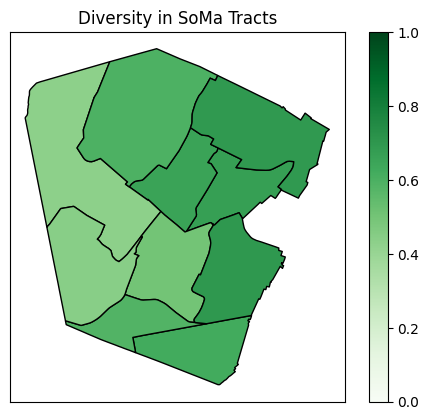

In [17]:
ax = gdf_essex_di.plot(
    "diversity",
    cmap="Greens",
    edgecolor="black",
    legend=True,
    vmin=0.0,
    vmax=1.0,
)

ax.set_title("Diversity in SoMa Tracts")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)

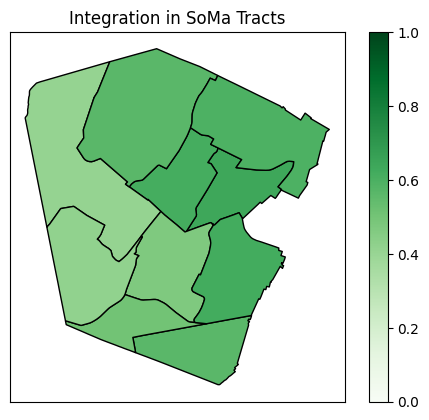

In [18]:
ax = gdf_essex_di.plot(
    "integration",
    cmap="Greens",
    edgecolor="black",
    legend=True,
    vmin=0.0,
    vmax=1.0,
)

ax.set_title("Integration in SoMa Tracts")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)